# Load the data

In [2]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the datset into a pandas dataframe
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/liveproject/mortgage_data_preprocessed.pkl.gz")

In [5]:
# install AIF360
!pip install aif360

     |████████████████████████████████| 184kB 8.9MB/s 
     |████████████████████████████████| 358kB 12.0MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=ba57748736ae9b6d06c65e2ee4c72e8fc79adac2bf960dc1543aa3452f1ec52f
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=c736746b89404408ce0a86257df4d399dc813a331e673605b116332ce5e3ba7b
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built memory-profiler shap


# Tune the thershold parameter

In [7]:
# Instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
folds = 10
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [8]:
# Tune the threshold using 10 fold cross validation

thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
import pandas as pd
import numpy as np
k, i = True, 0

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for fold_threshold in thresholds:
  av_f1 = 0
  av_acc = 0
  av_auc = 0
  av_precision = 0
  av_recall = 0
  av_statpar = 0
  av_av_odds = 0


  for (train, test) in mv.split(X, y):

      # fit model
      lr = lr.fit(X.iloc[train], y.iloc[train].values.ravel())
      
      # get predictions in the test set
      ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
      ypred_class = np.where(ypred_prob > fold_threshold, 1, 0)

      # compute performance metrics
      metrics = []
      metrics += [['Threshold', fold_threshold]]
      dataset = X.iloc[test].copy()
      dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
      dataset = BinaryLabelDataset(df=dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      dataset_pred = X.iloc[test].copy()
      dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
      dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)

      av_f1 += perf_metrics["F1-Score"](y.iloc[test].values.ravel(), ypred_class)
      av_acc += perf_metrics["Accuracy"](y.iloc[test].values.ravel(), ypred_class)
      av_auc += perf_metrics["AUC"](y.iloc[test].values.ravel(), ypred_class)
      av_precision += perf_metrics["Precision"](y.iloc[test].values.ravel(), ypred_class)
      av_recall += perf_metrics["Recall"](y.iloc[test].values.ravel(), ypred_class)
      av_statpar = metric_CM.statistical_parity_difference()
      av_av_odds = metric_CM.average_odds_difference()

    
  # Compute fairness metrics
  metrics += [['Threshold', fold_threshold]]
  metrics += [['F1', av_f1/folds]]
  metrics += [['Accuracy', av_acc/folds]]
  metrics += [['AUC', av_auc/folds]]
  metrics += [['Precision', av_precision/folds]]
  metrics += [['Recall', av_recall/folds]]
  metrics += [['Statistical Parity Difference', av_statpar/folds]]
  metrics += [['Average Odds Difference', av_av_odds/folds]]


  # concatenate results
  df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
  df_m["Fold"] = i
  i += 1
  if k:
      df_metrics = df_m.copy()
      k=0
  else:
      df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [9]:
# Display metrics
df_pivot = df_metrics.pivot_table(index="Fold", columns="Metric")["Value"]
df_pivot

Metric,AUC,Accuracy,Average Odds Difference,F1,Precision,Recall,Statistical Parity Difference,Threshold
Fold,,,,,,,,
0,0.715721,0.686622,0.010826,0.714767,0.585418,0.917564,0.016388,0.30
1,0.703582,0.692980,0.012379,0.684163,0.611094,0.777125,0.017541,0.40
2,0.694421,0.693257,0.012887,0.662144,0.626214,0.702491,0.017791,0.45
3,0.683385,0.692010,0.012212,0.634033,0.644909,0.623562,0.016825,0.50
4,0.670122,0.688671,0.011729,0.598105,0.668084,0.541450,0.015925,0.55
5,0.653645,0.682055,0.010412,0.551342,0.695897,0.456578,0.014098,0.60
6,0.612561,0.659446,0.006877,0.419178,0.775608,0.287342,0.009578,0.70


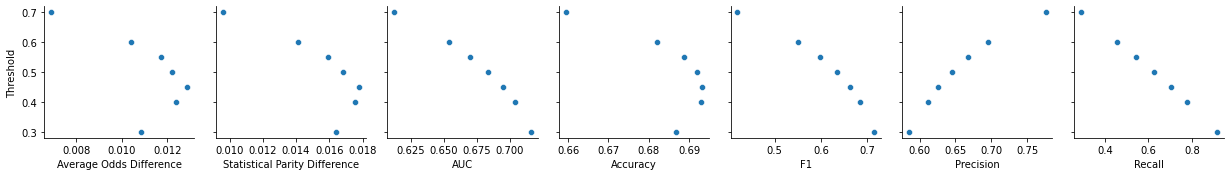

In [10]:
# Plot metrics against the threshold values
import seaborn as sns
y_vars = ['Threshold']
x_vars = ['Average Odds Difference', 'Statistical Parity Difference', 'AUC', 'Accuracy', 'F1', 'Precision', 'Recall']

g = sns.PairGrid(df_pivot, x_vars=x_vars, y_vars=y_vars)
g.map(sns.scatterplot)

# Re-run post-processing with two different classification thresholds.

In [12]:
# Instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
folds = 10
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [13]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Learn parameters to equalize odds and apply to create a new dataset
epp = EqOddsPostprocessing(privileged_groups = privileged_group,
                                     unprivileged_groups = unprivileged_group,
                                     seed=42)


In [14]:
# Train a logistic regression classifier with two different thresholds

thresholds = [0.45, 0.5]
import pandas as pd
import numpy as np
k, i = True, 0

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for fold_threshold in thresholds:
  av_f1 = 0
  av_acc = 0
  av_auc = 0
  av_precision = 0
  av_recall = 0
  av_statpar = 0
  av_av_odds = 0

  for (train, test) in mv.split(X, y):

      # fit model
      lr = lr.fit(X.iloc[train], y.iloc[train].values.ravel())
      
      # get predictions in the test set
      ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
      ypred_class = np.where(ypred_prob > fold_threshold, 1, 0)
      y_test = y.iloc[test]
      X_test = X.iloc[test]

      # fit post-processing using results from 60% of the test set
      test_pct = 0.4
      n = int(len(y_test))
      n_2 = int(n* (1-test_pct))
      indices = np.random.permutation(n)
      pp_indices = indices[:n_2]
      test_indices = indices[n_2:]

      pp_dataset = X_test.iloc[pp_indices].copy()
      pp_dataset[df.columns[-1]] = np.expand_dims(y_test.iloc[pp_indices], axis=1)
      pp_dataset_BLD = BinaryLabelDataset(df=pp_dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

      pp_pred = X_test.iloc[pp_indices].copy()
      pp_pred[df.columns[-1]] = np.expand_dims(ypred_class[pp_indices], axis=1)
      pp_pred_BLD = BinaryLabelDataset(df=pp_pred, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

      epp = epp.fit(pp_dataset_BLD, pp_pred_BLD)

      # Use epp to post-process predictions on the other 40% of the test set
      actuals_test = X_test.iloc[test_indices].copy()
      actuals_test[df.columns[-1]] = np.expand_dims(y_test.iloc[test_indices], axis=1)
      actuals_test_BLD = BinaryLabelDataset(df=actuals_test, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      pred_test = X_test.iloc[test_indices].copy()
      pred_test[df.columns[-1]] = np.expand_dims(ypred_class[test_indices], axis=1)
      pred_test_BLD = BinaryLabelDataset(df=pred_test, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

      transf_pred_test_BLD = epp.predict(pred_test_BLD)

      # compute performance metrics
      metrics = []
      metrics += [['Threshold', fold_threshold]]
      metric_CM = ClassificationMetric(actuals_test_BLD, transf_pred_test_BLD, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)

      av_f1 += perf_metrics["F1-Score"](y.iloc[test].values.ravel(), ypred_class)
      av_acc += perf_metrics["Accuracy"](y.iloc[test].values.ravel(), ypred_class)
      av_auc += perf_metrics["AUC"](y.iloc[test].values.ravel(), ypred_class)
      av_precision += perf_metrics["Precision"](y.iloc[test].values.ravel(), ypred_class)
      av_recall += perf_metrics["Recall"](y.iloc[test].values.ravel(), ypred_class)
      av_statpar = metric_CM.statistical_parity_difference()
      av_av_odds = metric_CM.average_odds_difference()

    
  # Compute fairness metrics
  metrics += [['Threshold', fold_threshold]]
  metrics += [['F1', av_f1/folds]]
  metrics += [['Accuracy', av_acc/folds]]
  metrics += [['AUC', av_auc/folds]]
  metrics += [['Precision', av_precision/folds]]
  metrics += [['Recall', av_recall/folds]]
  metrics += [['Statistical Parity Difference', av_statpar/folds]]
  metrics += [['Average Odds Difference', av_av_odds/folds]]


  # concatenate results
  df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
  df_m["Fold"] = i
  i += 1
  if k:
      df_metrics = df_m.copy()
      k=0
  else:
      df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Creating an 

In [15]:
# Display metrics
df_pivot = df_metrics.pivot_table(index="Fold", columns="Metric")["Value"]
df_pivot

Metric,AUC,Accuracy,Average Odds Difference,F1,Precision,Recall,Statistical Parity Difference,Threshold
Fold,,,,,,,,
0,0.694421,0.693257,-0.001735,0.662144,0.626214,0.702491,0.002255,0.45
1,0.683385,0.692010,-0.002744,0.634033,0.644909,0.623562,0.001569,0.50


The model that minimises false-negatives is the model with a threshold of 0.45.